## MCMC - Markov Chain Monte Carlo 

Markov chain Monte Carlo (MCMC) refers to a class of methods for sampling random vectors $X^{(0)}, X^{(1)}, ...$ (generally, they are not independent) from a multivariate distribution $f$. MCMC works by simulating a Markov chain in discrete time. One of the popular approaches of MCMC is Gibbs sampling. MCMC allows us to draw samples from any distribution that we can't sample from directly. It can be used to sample from the posterior distribution over parameters. It has seen much success in many applications, such as computing the distribution of parameters, given a set of observations and some prior belief, and also computing high dimensional integrals in physics and in digital communications.


### Bayesian statistics

Given some event B, what is the probability that event A occurs?. This is answered by Bayes' famous formula: 

$P(A|B) = P(B|A) \cdot P(A)$ / $P(B)$

$P(A|B)$ is the **posterior**. What we wish to compute.

$P(B|A)$ is the **likelihood**. Assuming $A$ occured, how likely is $B$.

$P(A)$ is the **prior**. How likely the event $A$ is regardless of evidence.

$P(B)$ is the **evidence**. How likely the evidence $B$ is regardless of the event.




$P(\theta|D) = P(D|\theta) \cdot P(\theta)$ / $P(D)$ where, $P(\theta|D)$ is the **posterior**, $P(D|\theta)$ is the **likelihood**, $P(\theta)$ is the **prior** and $P(D)$ is the **evidence**.
We would like to find the most likely distribution of $\theta $, the parameters of the model explaining the data, $D$.

### Metropolis-Hastings

MCMC is a class of methods. Metropolis-Hastings is a specific implementation of MCMC. It works well in high dimensional spaces as opposed to Gibbs sampling and rejection sampling.

This technique requires a simple distribution called the proposal distribution (transition model) $Q(\theta′|\theta)$ to help draw samples from an intractable posterior distribution $P(\Theta=\theta|D)$

Metropolis-Hastings uses $Q$ to randomly walk in the distribution space, accepting or rejecting jumps to new positions based on how likely the sample is. This "memoriless" random walk is the "Markov Chain" part of MCMC.

The "likelihood" of each new sample is decided by a function $f$. That's why $f$ must be proportional to the posterior we want to sample from. $f$ is commonly chosen to be a probability density function that expresses this proportionality.

To get a new position of the parameter, just take our current one $\theta$, and propose a new one $\theta′$, that is a random sample drawn from $Q(\theta′|\theta)$. Often this is a symmetric distribution. For instance, a normal distribution with mean $\theta$ and some standard deviation $\sigma$: $Q(\theta′|\theta) = \mathcal{N}(\theta, \sigma)$.

To decide if $\theta′$ is to be accepted or rejected, the following ratio must be computed for each new value of $\theta′$: 
$P(\theta′|D) P(\theta|D)$. Using Bayes' formula this can be easily re-formulated as: $r = \frac{P(D|\theta′)P(\theta′)}{P(D|\theta)P(\theta)}$ which is equivalent to $\frac{\prod_i^nf(d_i|\Theta=\theta′)P(\theta′)}{\prod_i^nf(d_i|\Theta=\theta)P(\theta)} = r$.


$P(accept) = 1$ if $r > 1, else: r$


#### Metropolis-Hastings Algorithm:

1. given:

    f, the PDF of the distribution to sample from $Q$, 
    
    the transition model $\theta$,
    
    a first guess for $\theta$
    
    $\theta = \theta_0$

2. for n iterations
    
    $P = f(D|\Theta=\theta)P(\theta)$
    
    $\Theta′= Q(\theta_i) $
    
    $P′ = f(D|\Theta=\theta′)P(\theta′)$
    
    ratio = $\frac{p′}{p}$
    
    generate a uniform random number t in [0,1]
    
    if $r$ set $\theta_i=\theta′$


In [12]:
import numpy as np
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'scipy'

## Example 1

#### Data generation

Generate 30000 samples from a normal distribution with $\mu$ = 10, and $\sigma$ = 3, but the observed data is 1000 of them.

9.914509586563215

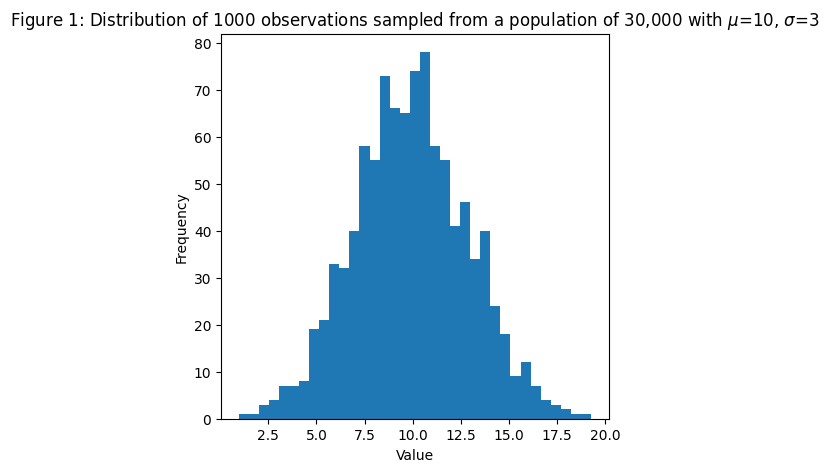

In [ ]:
# Form a population of 30,000 individual, with average=10 and scale=3
population = np.random.normal(10, 3, 30000)

# Assume we are only able to observe 1,000 of these individuals.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(5, 5))
plt.hist( observation,bins=35 ,)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs = observation.mean()
mu_obs

In [ ]:
# The tranistion model defines how to move from sigma_current to sigma_new
def transition_model(x):
    # x[0]=mu, x[1]=sigma (new or current)
    
    return[x[0], np.random.normal(x[1], 0.5, (1, ))[0]]


def prior(x):
    # x[0] = mu, x[1]=sigma (new or current)
    # returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    # returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    # It makes the new sigma infinitely unlikely.
    
    return 0 if x[1] <= 0 else 1


# Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    # x[0]=mu, x[1]=sigma (new or current)
    # data = the observation
    
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))


# Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    # x[0]=mu, x[1]=sigma (new or current)
    # data = the observation
    
    return np.sum(np.log(st.norm(x[0],x[1]).pdf(data)))


# Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer, prior, transition_model, param_init, iterations, data, acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

#### Run the algorithm with initial parameters and collect accepted and rejected samples

In [ ]:
params = (manual_log_like_normal, prior, transition_model, [mu_obs,0.1], 50000, observation, acceptance)

accepted, rejected = metropolis_hastings(*params)

The algorithm accepted 8219 samples (which might be different on each new run). The last 10 samples contain the following values for $\sigma$:

In [ ]:
accepted[-10:,1]

array([2.96367516, 2.85757293, 2.90200004, 2.81545918, 2.88517724,
       2.9627258 , 2.87702597, 2.94495201, 3.02288722, 2.91664987])

In [ ]:
print(accepted.shape)

(8219, 2)


(8219, 2)

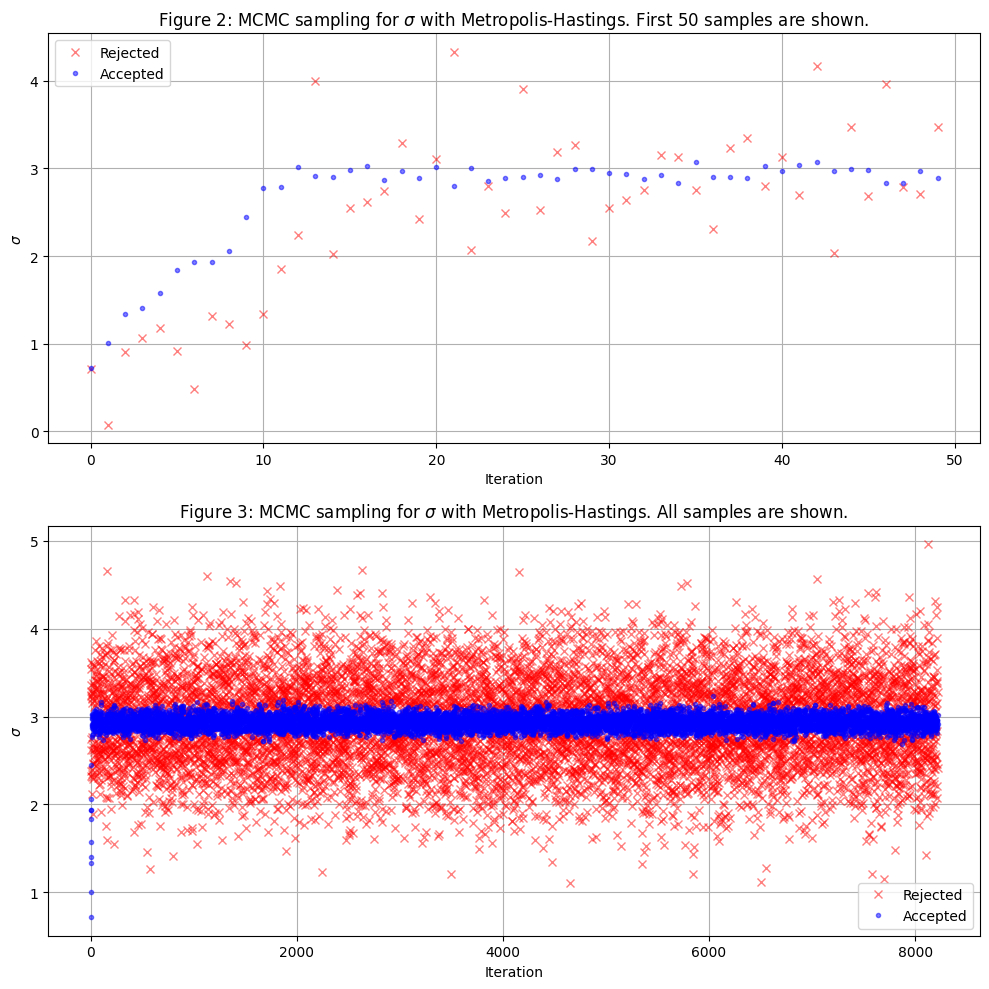

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot(rejected[0:50,1], 'rx', label='Rejected', alpha=0.5)
ax.plot(accepted[0:50,1], 'b.', label='Accepted', alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected', alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted', alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

So, starting from an initial $\sigma$ of 0.1, the algorithm converged pretty quickly to the expected value of 3. That said, it's only sampling in a 1D space…. so it's not very surprising.

We consider the initial 25% of the values of $\sigma$ to be "burn-in", so we drop them.

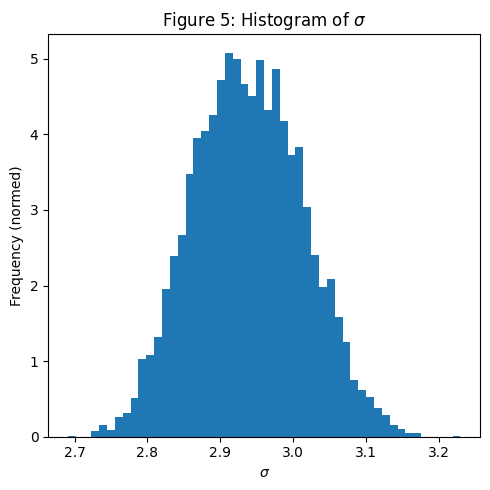

In [ ]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(5, 5))
# ax = fig.add_subplot(1,2,1)
# ax.plot(accepted[show:,1])
# ax.set_title("Figure 4: Trace for $\sigma$")
# ax.set_ylabel("$\sigma$")
# ax.set_xlabel("Iteration")
# ax = fig.add_subplot(1,2,2)
ax = fig.add_subplot(1, 1, 1)
ax.hist(accepted[hist_show:,1], bins=50,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogram of $\sigma$")
fig.tight_layout()


# ax.grid("off")

#### Predictions:

First, we average the last 75% of accepted samples of $\sigma$, and we generate $30,000$ random individuals from a normal distribution with $\mu = 9.9$ and $\sigma = 2.94$ (the average of the last 75% of accepted samples).

9.914509586563215 2.9388540300397485


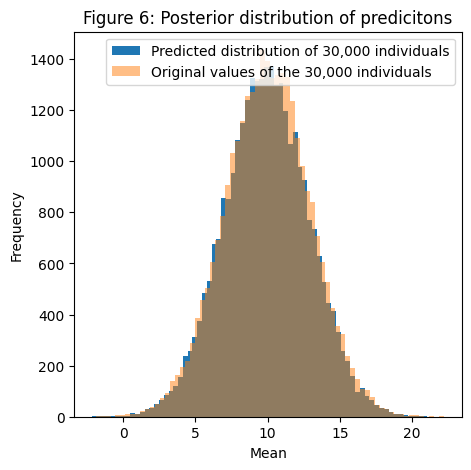

In [ ]:
mu = accepted[show:,0].mean()
sigma = accepted[show:,1].mean()
print(mu, sigma)

observation_gen = np.random.normal(mu, sigma, population.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(observation_gen, bins=70 ,label="Predicted distribution of 30,000 individuals")
ax.hist(population, bins=70, alpha=0.5, label="Original values of the 30,000 individuals")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Figure 6: Posterior distribution of predicitons")
ax.legend()
plt.show()

## Example 2 (Astrophysics)

<img src="Sunspot1.jpg" width="1000">

Credit: Amateur astronomer Alan Friedman on July 10, 2012.

A sunspot is a region on the Sun's surface (photosphere) that is marked by a lower temperature than its environment. These reduced temperatures are caused by concentrations of magnetic field flux that inhibit convection by an effect similar to eddy current brakes. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

The data we will be working on is the "Monthly mean total sunspot number", for each month from January 1749 to November 2018. This is data collected, curated and made publicly available by the World Data Center for the production, preservation and dissemination of the international sunspot number.

(3238,) (3238,)
1785.042


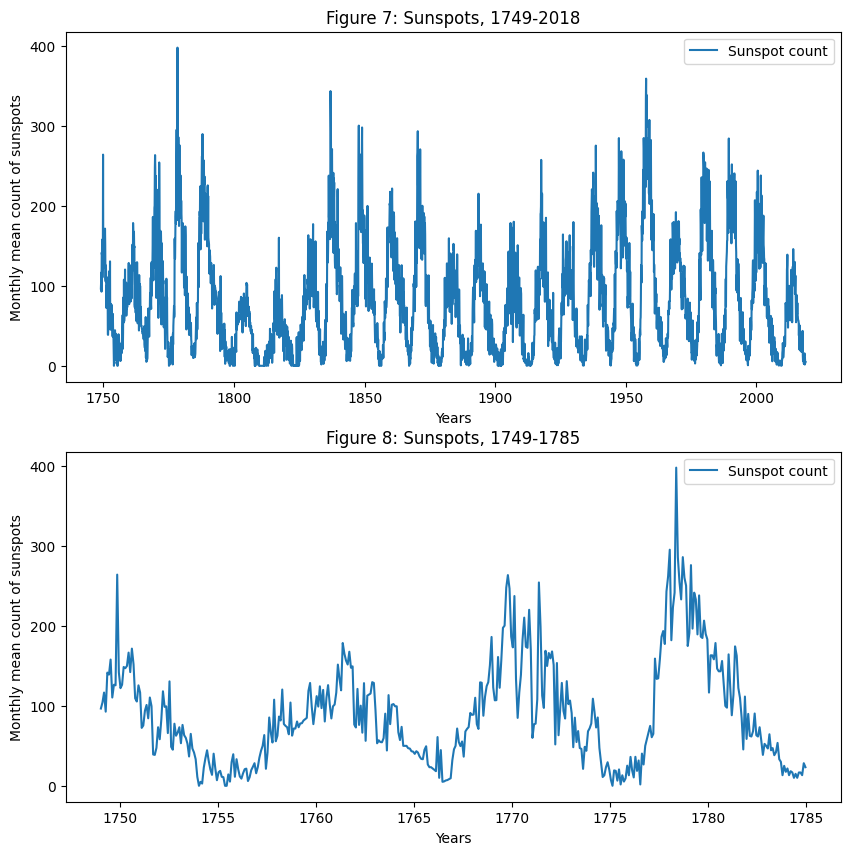

In [ ]:
sunspots = np.loadtxt("SN_m_tot_V2.0.csv", delimiter=';')

# years is the third column
years = sunspots[:,2]

# activity is the 4th column
activity = sunspots[:,3] + 0.1
print(years.shape, activity.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2, 1, 1)

ax.plot(years, activity, label="Sunspot count")
ax.set_yticks(np.arange(0, 500, 100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 7: Sunspots, 1749-2018")
ax.legend()


ax = fig.add_subplot(2,1,2)
print(years[432])
ax.plot(years[:432], activity[:432], label="Sunspot count")
ax.set_yticks(np.arange(0, 500, 100))
ax.set_xlabel("Years")
ax.set_ylabel("Monthly mean count of sunspots")
ax.set_title("Figure 8: Sunspots, 1749-1785")
ax.legend()

It seems like we could model this phenomenon with a gamma distribution, with a new cycle resetting every 12 years.

A gamma distribution Γ is a two-parameter family of continuous probability distributions, the parameters are the shape a and the scale b. A random variable X that is gamma-distributed is noted X~Γ(a, b), and in our case X is the count of sunspots. The two parameters a and b are the unknowns that we would like to calculate distributions for.

<img src="gamma.PNG" width="500">
Wikipedia Commons.

For example, in the first cycle, the sunspot counts start from their highest at about 300 at the end of 1749, and fall to their lowest 6 years after, during 1755. Then the number rises up again to it's maximum during 1761 and 1762 before falling again during 1766 and so on...

**Let's make sure by plotting a histogram of sunspot counts:**

Text(0.5, 1.0, 'Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)')

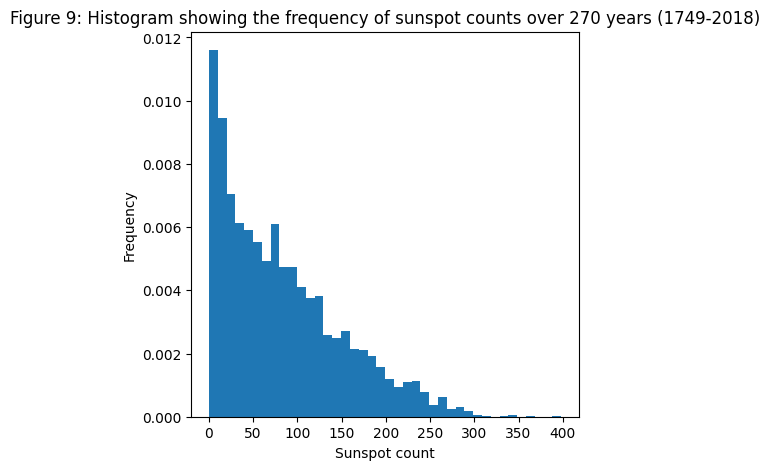

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.hist(activity, bins=40, density=True)
ax.set_xlabel("Sunspot count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 9: Histogram showing the frequency of sunspot counts over 270 years (1749-2018)")

In [ ]:
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,))

import math

def prior(w):
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1
    
def manual_log_lik_gamma(x,data):
    return np.sum((x[0]-1)*np.log(data) - (1/x[1])*data - x[0]*np.log(x[1]) - np.log(math.gamma(x[0])))
    
def log_lik_gamma(x,data):
    return np.sum(np.log(scipy.stats.gamma(a=x[0],scale=x[1],loc=0).pdf(data)))    

In [ ]:
accepted, rejected = metropolis_hastings(manual_log_lik_gamma,prior,transition_model,[4, 10], 50000,activity,acceptance)

In [ ]:
print(accepted.shape)
accepted[-10:]

(8489, 2)


array([[ 1.01179922, 84.2026826 ],
       [ 1.01567568, 80.84228585],
       [ 0.99787378, 84.93278983],
       [ 1.01888624, 82.59662426],
       [ 1.00546248, 82.81613563],
       [ 0.96705715, 86.92830013],
       [ 0.97745094, 85.72094413],
       [ 0.99520627, 80.59199064],
       [ 1.01812089, 80.25726206],
       [ 1.00802799, 84.5064406 ]])

Starting from a=4, and b =10, the algorithm accepted 8489 pairs of samples, the last value for a is 1.01307402 and the last value for b is 83.40995308, which are pretty far off the initial values.

Text(0.5, 1.0, 'Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.')

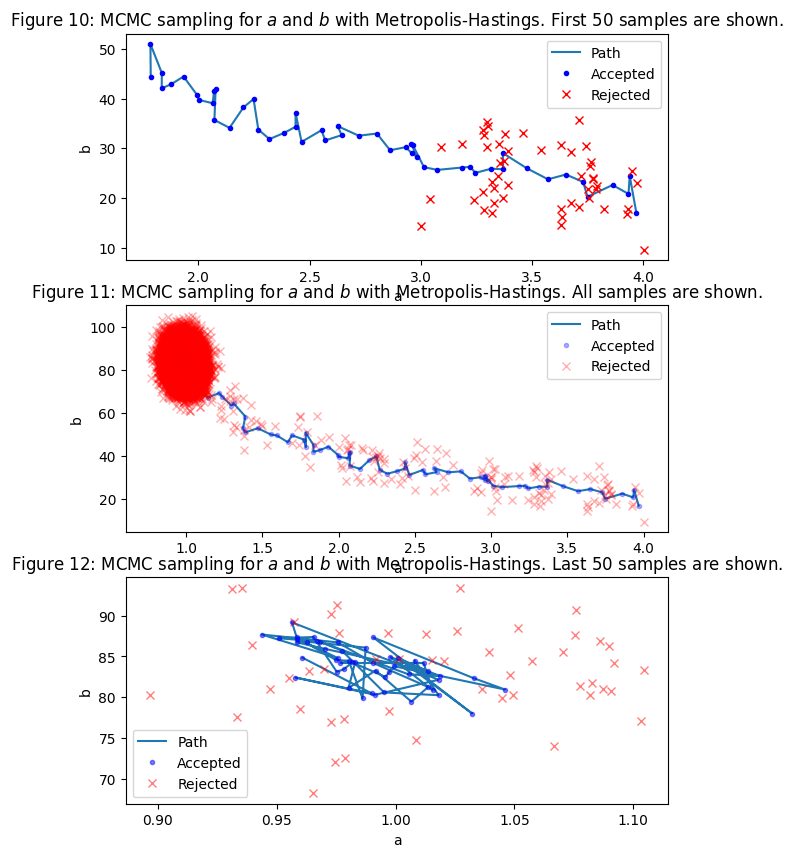

In [ ]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(3,1,1)
ax.plot(accepted[:50,0], accepted[:50,1], label="Path")
ax.plot(accepted[:50,0], accepted[:50,1], 'b.', label='Accepted')
ax.plot(rejected[:50,0], rejected[:50,1], 'rx', label='Rejected')
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 10: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. First 50 samples are shown.")  


ax = fig.add_subplot(3,1,2)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 11: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. All samples are shown.") 

to_show=50
ax = fig.add_subplot(3,1,3)
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], label="Path")
ax.plot(accepted[-to_show:,0], accepted[-to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax.plot(rejected[-to_show:,0], rejected[-to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.legend()
ax.set_title("Figure 12: MCMC sampling for $a$ and $b$ with Metropolis-Hastings. Last 50 samples are shown.") 

Text(0.5, 1.0, '2D histogram showing the joint distribution of $a$ and $b$')

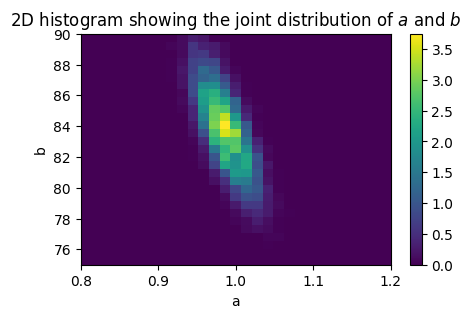

In [ ]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(0.8,1.2,30), np.linspace(75,90,30)
counts, xedges, yedges, im = ax.hist2d(accepted[hist_show:,0], accepted[hist_show:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("a")
ax.set_ylabel("b")
fig.colorbar(im, ax=ax)
ax.set_title("2D histogram showing the joint distribution of $a$ and $b$")

0.9855127354860621 83.86487085520253


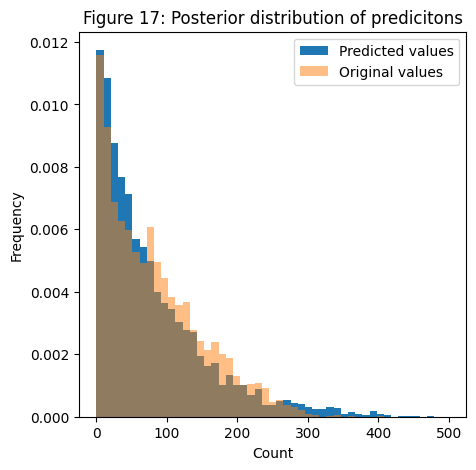

In [ ]:
show =- int(0.5 * accepted.shape[0])

mu = accepted[show:, 0].mean()
sigma = accepted[show:, 1].mean()
print(mu, sigma)

model = lambda t, mu, sigma: np.random.gamma(mu, sigma, t)

t = np.arange(activity.shape[0])
observation_gen = model(t.shape[0], mu, sigma)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)



ax.hist(observation_gen, bins=np.linspace(0,500,50), density=True, label="Predicted values")
ax.hist(activity,bins = np.linspace(0,500,50), alpha=0.5, density=True, label="Original values")
ax.set_xlabel("Count")
ax.set_ylabel("Frequency")
ax.set_title("Figure 17: Posterior distribution of predicitons")
ax.legend()

### Evaluation

#### Evaluation of the proposal distribution

How do we specify the parameters for the distribution Q? Should we move far from the current sample θ, or stay relatively close? These questions can be answered by measuring the auto-correlation between accepted samples: we do not want the accepted samples to be too correlated between one another. We don't want distant samples to be too correlated as we are trying to implement a markov chain, i.e. a sample should only depend on its previous sample, and the auto-correlation plot should show a quick, exponential decrease between the correlation of sample i and i-1,i-2,...i-n

The auto-correlation is defined by computing the following function for each lag $k$: $r_k = \frac{\sum_{i=1}^{N-k}(Y_i - Y_{avg})(Y_{i+k}-Y_{avg})}{\sum_{i=1}^{N-k}(Y_i - Y_{avg})^2}$.

The lag $k$, is basically the range around a sample $Y_i$ in which we would like to measure the correlation.

The plots below show the auto-correlation for a, b for k going from 1 to 100. A lag of k=1 means that we are measuring the correlation of a sample with itself, so we expect it to be equal to 1. The higher k goes, the lower that correlation ought to be.

0.9855127354860621 83.86487085520253


[Text(0.5, 0, 'lag'), Text(0, 0.5, 'autocorrelation'), (-0.1, 1.0)]

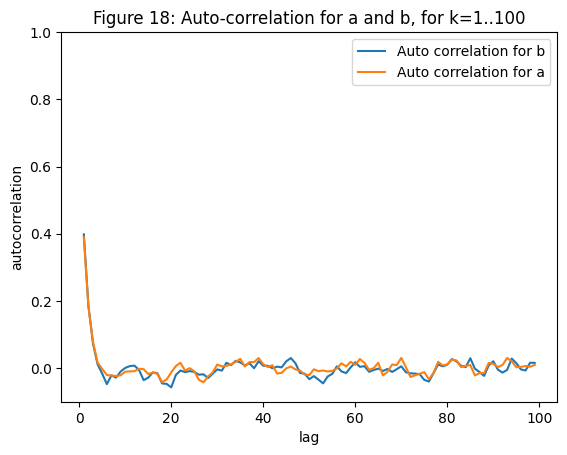

In [ ]:
mean_acc_0 = accepted[show:, 0].mean()
mean_acc_1 = accepted[show:, 1].mean()
print(mean_acc_0, mean_acc_1)

lag = np.arange(1,100)
def autocorr(accepted, lag):
    num_0, num_1, denom_0, denom_1 = 0, 0, 0, 0
    
    for i in range(accepted.shape[0] - lag):
        num_0 += (accepted[i, 0] - mean_acc_0) * (accepted[i+lag, 0] - mean_acc_0)
        num_1 += (accepted[i, 1] - mean_acc_1) * (accepted[i+lag, 1] - mean_acc_1)
        denom_0 += (mean_acc_0 - accepted[i, 0]) ** 2
        denom_1 += (mean_acc_1 - accepted[i, 1]) ** 2
    rk_0 = num_0 / denom_0
    rk_1 = num_1 / denom_1
    return rk_0, rk_1


accepted_reversed = accepted[show:, :]
result = np.zeros((2,lag.shape[0]))
#print(lag)
for l in lag:
    result[:, l-1] = autocorr(accepted_reversed, l)
    
    
### Instead of writing an autocorrelation function, one could simply use thee autocorr function provided in pymc3    
# from pymc3.stats import autocorr

fig, ax = plt.subplots()
#ax.plot(lag, [autocorr(accepted[show:,1], l) for l in lags], label='auto b')
#ax.plot(lag, [autocorr(accepted[show:,0], l) for l in lags], label='auto a')
ax.plot(lag, result[1, :], label='Auto correlation for b')
ax.plot(lag, result[0, :], label='Auto correlation for a')
ax.legend(loc=0)
ax.set_title("Figure 18: Auto-correlation for a and b, for k=1..100")
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

In our case, we are lucky to have a low enough correlation. In general, we might want to setup the parameters of the proposal distribution, Q, automatically, one common method is to keep adjusting the proposal parameters so that more than 50% proposals are rejected. Alternatively, one could use an enhanced version of MCMC called Hamiltonian Monte Carlo, which reduces the correlation between successive sampled states and reaches the stationary distribution quicker.

### Conclusion

While the abstraction behind this algorithm may seem out of grasp at first, the implementation is actually pretty simple, and gives awesome results. In fact, the great thing about probabilistic programming, notably MCMC is that you only need to write down the model and then run it. There is no need to compute evidence, or ensure some constraining mathematical properties.